# Recovering Pulse-Response Treatment Dynamics
This notebook uses the `ContextualizedUnivariateRegression` class to recover nonlinear models of treatment response by estimating linear models for many individual patients

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from contextualized.regression import ContextualizedUnivariateRegression, UnivariateDataset, MSE

## Phenotype-specific simulations of pulse-response

gene b is modeled as a hill function response to a pulse of drug a. 
Assign each patient a phenotype that parameterizes this hill function and simulate to a random timestep.

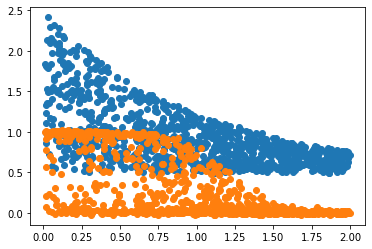

In [217]:
# Per patient params
a_ss = .5
a0 = a_ss
b0 = 0
da = lambda a: -a + a_ss
db = lambda a, kd, kn: ((a**kn) * (kn * a**(kn - 1)) - (kn * a**(kn - 1)) * (kd + a**kn)) / (kd + a**kn)**2  # f*g' - f'*g/g'^2
b_hill = lambda a, kd, kn: (a**kn) / (kd + a**kn)
tp = 1

def simulate(tn, ap, kd, kn):
    a = ap
    dadt = None
    b = b0
    dbda = None
    t = 0
    dt = 0.01
    while t < tn:
        dadt = da(a)
        a += dt * dadt
        dbda = db(a, kd, kn)
        b = b_hill(a, kd, kn)
        t += dt
    return a, b, dadt, dbda

# Phenotypes
n = 1000
tn_arr = np.random.uniform(0.01, 2, n)  # sampling timepoint
# tn_arr = np.random.uniform(0.01, 2, n)  # sampling timepoint
ap_arr = np.random.uniform(.5, 2.5, n) # treatment pulse magnitude
# ap_arr = np.ones(n) * 2
# kd_arr = np.random.uniform(2, 4, n)  # phenotype dissociation equillibrium
# kd_arr = np.ones(n) * 3
kn_arr = np.ones(n) * 12  # hill coefficient
epsilon = np.random.normal(0, 0.01, n)

a_arr = np.zeros(n)
b_arr = np.zeros(n)
# TODO: log all du/dv
dadt_arr = np.zeros(n)
dbda_arr = np.zeros(n)
for i, vals in enumerate(zip(tn_arr, ap_arr, kd_arr, kn_arr)):
    a_arr[i], b_arr[i], dadt_arr[i], dbda_arr[i] = simulate(*vals)
    a_arr[i] += np.random.normal(0, 0.01)
    b_arr[i] += np.random.normal(0, 0.01)

plt.scatter(tn_arr, a_arr, label='a')
plt.scatter(tn_arr, b_arr, label='b')
plt.show()

## Mise en Place

In [230]:
shape = (n, 1)
tn_arr, ap_arr, kd_arr, kn_arr, a_arr, b_arr, dbda_arr = tn_arr.reshape(shape), ap_arr.reshape(shape), kd_arr.reshape(shape), kn_arr.reshape(shape), a_arr.reshape(shape), b_arr.reshape(shape), dbda_arr.reshape(shape)
C = np.concatenate((tn_arr, ap_arr, kd_arr, kn_arr), axis=1)
# C  = tn_arr.copy()
C = (C - C.mean()) / C.std() # standardize context
# C = np.concatenate((tn_arr, a_arr), axis=1)
X = np.concatenate((a_arr, b_arr), axis=1)
Y = X
# X = a_arr.copy()
# Y = b_arr.copy()
beta = dbda_arr.copy()
C.shape, X.shape, beta.shape
train_idx = np.arange(int(.8 * n))
val_idx = np.arange(int(.8 * n), int(.9 * n))
test_idx = np.arange(int(.9 * n), n)
C_train, X_train, Y_train, beta_train = C[train_idx], X[train_idx], Y[train_idx], beta[train_idx]
C_val, X_val, Y_val, beta_val = C[val_idx], X[val_idx], Y[val_idx], beta[val_idx]
C_test, X_test, Y_test, beta_test = C[test_idx], X[test_idx], Y[test_idx], beta[test_idx]
C_test.shape, X_test.shape, Y_test.shape, beta_test.shape

def diagnose(model):
#     print(f'beta_arch F-norm: {np.linalg.norm(model.model.beta_archetypes.detach().numpy(), 2)}')
    beta_hat_test, mu_hat_test = model.predict_coefs(C_test)
    beta_hat_test = beta_hat_test[:,0,1].reshape((100, 1))
    mu_hat_test = mu_hat_test[:,0,1].reshape((100, 1))
    beta_hat_train, mu_hat_train = model.predict_coefs(C_train)
    beta_hat_train = beta_hat_train[:,0,1].reshape((800, 1))
    mu_hat_train = mu_hat_train[:,0,1].reshape((800, 1))
    tn_train, a_train, b_train = tn_arr[train_idx], a_arr[train_idx], b_arr[train_idx]
    b_pred_train = beta_hat_train * a_train + mu_hat_train
    tn_test, a_test, b_test = tn_arr[test_idx], a_arr[test_idx], b_arr[test_idx]
    b_pred_test = beta_hat_test * a_test + mu_hat_test
#     print(f'beta_hat F-norm: {np.linalg.norm(beta_hat_test, 2)}')
#     print(f'mu_hat F-norm: {np.linalg.norm(mu_hat_test, 2)}')
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    axs[0].scatter(tn_train, a_train)
    axs[0].scatter(tn_train, b_train)
    axs[0].scatter(tn_train, b_pred_train)
    axs[0].set_title('Train')
    
    axs[1].scatter(tn_test, a_test)
    axs[1].scatter(tn_test, b_test)
    axs[1].scatter(tn_test, b_pred_test)
    axs[1].set_title('Test')
#     plt.savefig('figures/pulse_220131.png')
    plt.show()

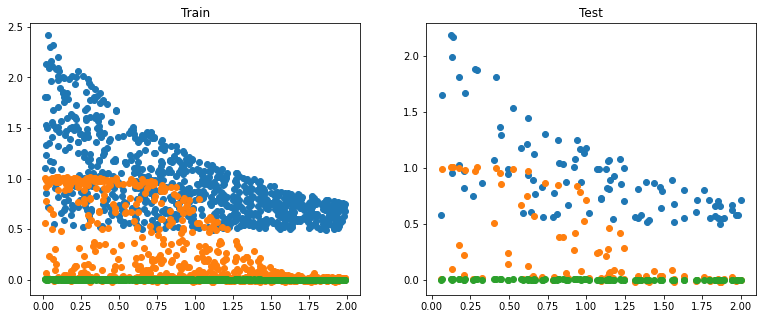

ContextualizedRegressionModule(
  (context_encoder): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=4, out_features=25, bias=True)
      (1): ReLU()
      (2): Linear(in_features=25, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=20, bias=True)
    )
  )
  (task_encoder): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=4, out_features=25, bias=True)
      (1): ReLU()
      (2): Linear(in_features=25, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=20, bias=True)
    )
  )
  (softselect): SoftSelect()
)

In [220]:
model = ContextualizedUnivariateRegression(C.shape[-1], X.shape[-1], Y.shape[-1], subtype='modal', num_archetypes=20, encoder_layers=3)
diagnose(model)
model.model

In [222]:
model.fit(C_train, X_train, Y_train, 20, 1, lr=1e-3)

[Train MSE: 0.0003] [Sample: 3199/3200] Epoch: 100%|█| 20/20 [05:16<00:00, 15


## Compare to true pulse-response timelines

In [227]:
def plot_case(ap, kd, kn, a_idx=0, b_idx=1):
    a_ss = .5
    a0 = a_ss
    b0 = 0
    da = lambda a: -a + a_ss
    db = lambda a, kd, kn: ((a**kn) * (kn * a**(kn - 1)) - (kn * a**(kn - 1)) * (kd + a**kn)) / (kd + a**kn)**2  # f*g' - f'*g/g'^2
    b_hill = lambda a, kd, kn: (a**kn) / (kd + a**kn)
    tp = 1

    def simulate(tn, ap, kd, kn):
        a = ap
        dadt = None
        b = b0
        dbda = None
        t = 0
        dt = 0.01
        while t < tn:
            dadt = da(a)
            a += dt * dadt
            dbda = db(a, kd, kn)
            b = b_hill(a, kd, kn)
            t += dt
        return a, b, dadt, dbda

    # Phenotypes
    n = 1000
    tn_arr = np.random.uniform(0.01, 1, n)  # sampling timepoint
    # ap_arr = np.random.uniform(.5, 2, n) # treatment pulse magnitude
    ap_arr = np.ones(n) * ap
    # kd_arr = np.random.uniform(.5, 2, n)  # phenotype dissociation equillibrium
    # kd_arr[kd_arr < 0.1] = 2
    kd_arr = np.ones(n) * kd
    kn_arr = np.ones(n) * kn  # hill coefficient
    epsilon = np.random.normal(0, 0.01, n)

    a_arr = np.zeros(n)
    b_arr = np.zeros(n)
    dadt_arr = np.zeros(n)
    dbda_arr = np.zeros(n)
    for i, vals in enumerate(zip(tn_arr, ap_arr, kd_arr, kn_arr)):
        a_arr[i], b_arr[i], dadt_arr[i], dbda_arr[i] = simulate(*vals)
        a_arr[i] += np.random.normal(0, 0.01)
        b_arr[i] += np.random.normal(0, 0.01)

    shape = (n, 1)
    C = np.stack((tn_arr, ap_arr, kd_arr, kn_arr), axis=1)
    C = (C - C.mean()) / C.std() # standardize context

    beta_hat_all, mu_hat_all = model.predict_coefs(C)
    beta_hat = beta_hat_all[:,a_idx,b_idx]
    mu_hat = mu_hat_all[:,a_idx,b_idx]
    plt.scatter(tn_arr, a_arr, label='Treatment Pulse')
    plt.scatter(tn_arr, b_arr, label='True Gene Response')
    plt.scatter(tn_arr, beta_hat * a_arr + mu_hat, label='Sample-specific Linear Models')
    plt.ylim(-.1, 2)
    plt.legend()
    # plt.savefig('figures/sanitycheck_220203.png')
    plt.show()

Treatment Pulse: 1


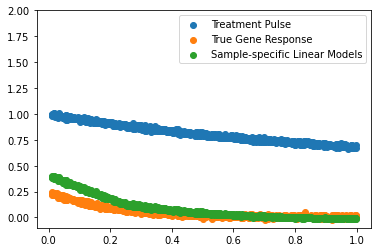

Treatment Pulse: 1.25


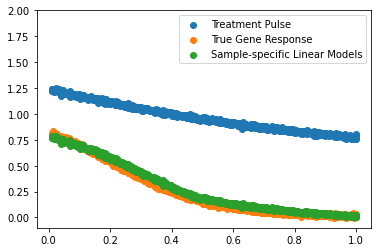

Treatment Pulse: 1.5


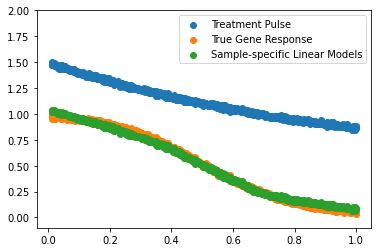

Treatment Pulse: 1.75


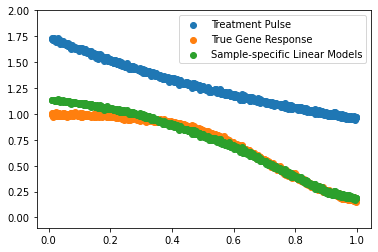

Treatment Pulse: 2


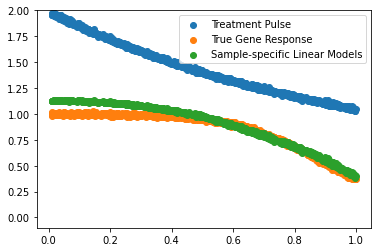

In [232]:
for ap in [1, 1.25, 1.5, 1.75, 2]:
    print(f"Treatment Pulse: {ap}")
    for kd in [3]:
        for kn in [12]:
            plot_case(ap, kd, kn)

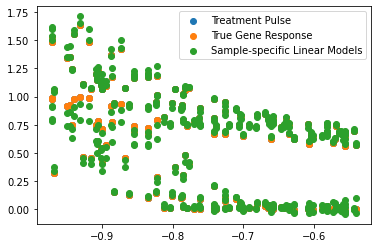

In [216]:
test_dataset = UnivariateDataset(C_test, X_test, Y_test, batch_size=np.inf)
c, t, x, y = next(test_dataset)
module = model.models[0]
beta_hat, mu_hat = module(c, t)
beta_hat = beta_hat.detach()
mu_hat = mu_hat.detach()
time = c[:,0]
plt.scatter(time, x, label='Treatment Pulse')
plt.scatter(time, y, label='True Gene Response')
plt.scatter(time, beta_hat * x + mu_hat, label='Sample-specific Linear Models')
plt.legend()
# plt.savefig('figures/sanitycheck_220203.png')
plt.show()